In [2]:
from occupancy import *

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Data Preparation

In [4]:
alpha = 0.3
noise_level = 0
obj1, obj0 =  make_objs(blur_by=2) # previous image 
obj1, obj0 =  make_objs(n_pos=50,blur_by=5, delta_x=-7, delta_y=7, seed=4) # simpler image
vmax = np.max(obj0)
# obj1, obj0 = obj1/vmax, obj0/vmax
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=False)
# make_working_vars(obj1, obj0, alpha, old_version=True) 


I simplified the image compared to what was there before.

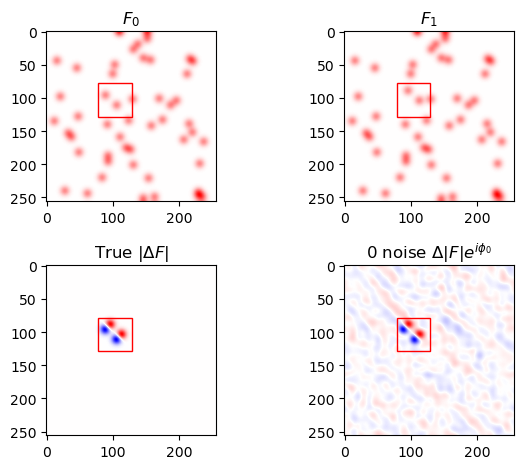

In [5]:
from matplotlib import patches 
fig, axsi = plt.subplots(2,2, tight_layout=True)
axs = axsi.flat
img_mid = 128
boxleng = -50

obj_diff = obj1-obj0
f_diff = np.fft.fftn(obj_diff)
obj_diff_conj = np.fft.ifftn(np.conj(f_diff)* np.exp(2j*np.angle(f_dark))).real
obj_diff_comb = (obj_diff + obj_diff_conj)/2


for ax in axs:
    rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
ax = axs[0]
ax.set_title(r"$F_0$")
ax.imshow(obj0, cmap= "bwr", vmin=-np.max(obj0))
ax = axs[1]
ax.set_title(r"$F_1$")
ax.imshow(obj1, cmap= "bwr", vmin = -np.max(obj0))

ax = axs[2]
ax.set_title(r"True $|\Delta F|$")
ax.imshow(obj_diff, cmap = "bwr", )

ax = axs[3]
ax.set_title(r"0 noise $\Delta |F|e^{i\phi_0}$")
ax.imshow(obj_diff_comb, cmap = "bwr",)
plt.show()


In [6]:
iso_diff_test = np.sum(np.abs(f_diff)) / np.sum(np.abs(f_dark))
print(f"Test whether F_Diff/F_0 ratio {iso_diff_test:.2f} < 0.25")

Test whether F_Diff/F_0 ratio 0.18 < 0.25


Calculate $F_{xtr}$ as 
$$ 
F_{xtr} = 2/\alpha_{xtr}*\Delta |F| e^{i\phi_0}+F_0
$$

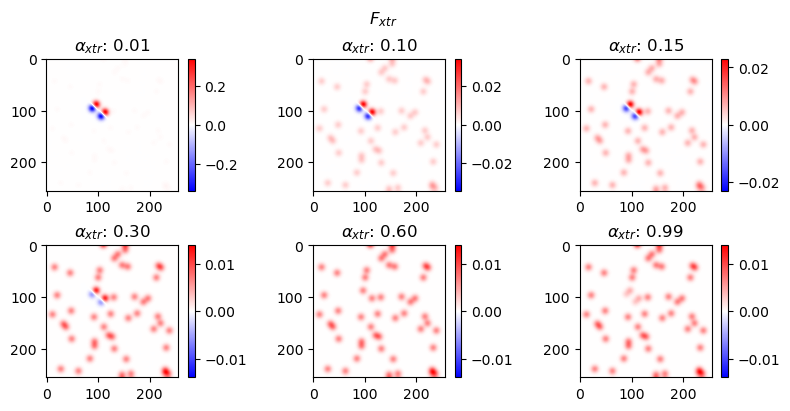

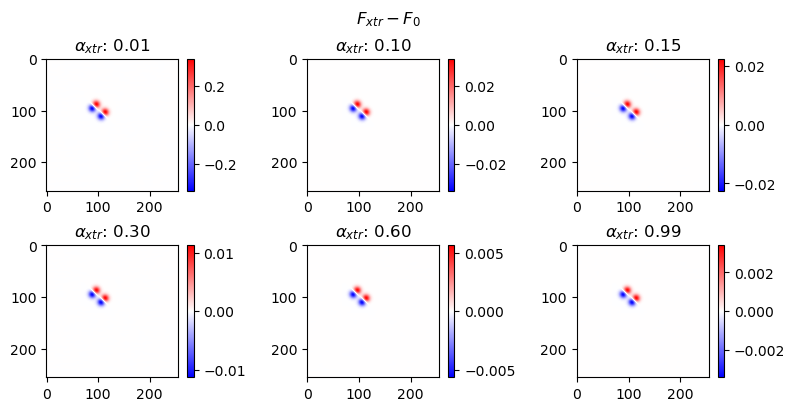

In [10]:
alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .99])
f_xtrs_vis = make_f_xtr_phased(alpha_xtrs_vis, f_dark, f_light-f_dark, noise_level = 0)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig1, axs1 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
fig2, axs2 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1
for ax1,ax2, alpha_xtr, arr in zip(axs1.flat,axs2.flat, alpha_xtrs_vis,dens_xtrs_vis):
    rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax1.set_title(tit)
    ax2.set_title(tit)
    vmax = np.max(arr)
    im = ax1.imshow(arr, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    
    diff = (arr-obj0)
    vmax = np.max(diff)
    im = ax2.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    
fig1.suptitle("$F_{xtr}$")
fig2.suptitle("$F_{xtr} - F_0$")

plt.show()    


Going from $F_{diff}$ to something closely resembling $F_0$. The factor 2 is tucked away in the formula for $F_{xtr}$. 
The true value for the occupancy is thus exactly `alpha`. 
We see for the case of $F_{xtr}$ that for low assumed occupancy $\Delta F$ dominates.
For large assumed occupancies, we do not obtain $F_0$ but something close to it.

In the case of $F_{xtr} - F_0$, everything looks the same, except for the scale.
This should not be surprising given the definition of $F_{xtr}$.
The Fourier transfrom is linear, so we just look at $\Delta |F| e^{i\phi_0} + F_0 - F_0$, so apart from the prefactor $\alpha_{xtr}$ nothing _should_ change.
Yet, this is the basis for Elke's 'difference map analysis method'. 
This perplexed me a bit - until I remembered that I had seen the `normalize_array` function in the Xtrapol8 code.
I assumed that this was only necessary because experimental data is complicated.
But when adding the norm defined as `arr/np.max(arr)`, I got the below.


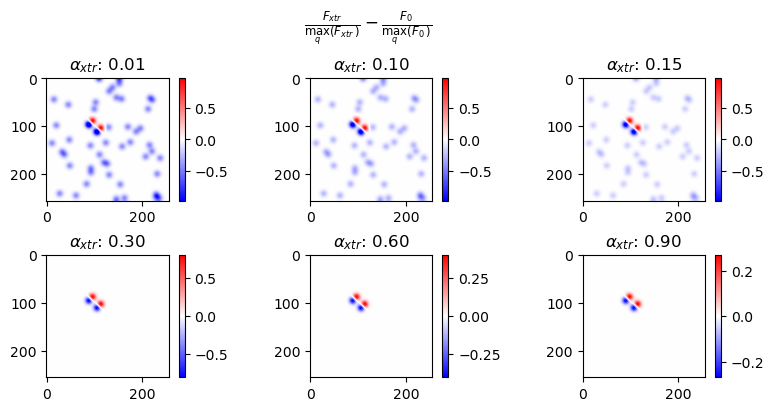

In [11]:
# make_working_vars(obj1, obj0, alpha, old_version=True) 

alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .9])
f_xtrs_vis = make_f_xtr_phased(alpha_xtrs_vis, f_dark, f_light-f_dark, noise_level = 0)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1

for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs_vis):
    
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax.set_title(tit)
    diff = arr/np.max(arr)-obj0/np.max(obj0)
    vmax = np.max(diff)
    im = ax.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
plt.suptitle(r"$\frac{F_{xtr}}{\max_q(F_{xtr})} - \frac{F_0}{\max_q(F_0)}$")
plt.show()    

For low assumed occupancy, everything is scaled up but this seems to be more than linear:
The most prominent peaks, i.e. the true difference peaks, grow more in value than the rest.
This means, we see the difference peaks clearly.
Outside the region of change - everything else being scaled down in $F_{xtr}$ - we therefore observe a negative correlation to $F_0$.

For larger assumed occupancies these difference seem to diminish and the overall intensity decreases. Without more noise, not much else seems to happen. 
Due to the rescaling, it does not seem to be guaranteed that the optimal guess should correspond to the true occupancy. 

I asked myself why the method is off by a bit in one or the other direction. But I guess my eyes would be off, too.

# Difference map analysis (Xtrapol8)

First I define a region of interest. Plots didn't change much based on whether I drew this region more or less stringent. As we only care about the overall sum, the largest value are of the most interest - which by this simple measure should always be captured.

A common source for errors is that this value is chosen too high - leading to a mask without matches.

Text(0.5, 1.0, 'Mask for Xtrapol8')

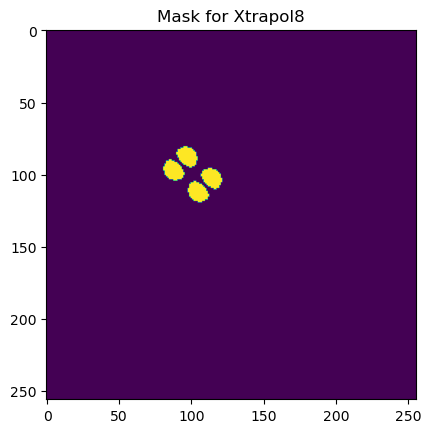

In [16]:
delta_obj = alpha*(obj1-obj0)
mask_pks = np.abs(delta_obj)>0.0005
fig, axs = plt.subplots(1,1)
# ax = axs[0]
axs.imshow(mask_pks)
axs.set_title("Mask for Xtrapol8")
# ax = axs[1]
# ax.imshow(mask_pks)

In [72]:
from occupancy import  x8_density_map_fdiff_factor

alpha_xtrs = np.linspace(5e-3,1,250 )

f_xtrs = make_f_xtr_phased(alpha_xtrs, f_dark, (f_light-f_dark), noise_level = 0)
peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diff, real_CC_diff = x8_density_map_fdiff(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diffnorm, real_CC_diffnorm, fract = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj, inspect=True)
peak_sum_difffact, real_CC_difffact = x8_density_map_fdiff_factor(f_xtrs/alpha_xtrs[:,None,None], mask_pks, obj0, delta_obj, 1)
peak_sum_diff_noisyf0, real_CC_diff_noisyf0 = x8_density_map_fdiff_noisyf0(f_xtrs, mask_pks, obj0, delta_obj)

#print(np.max(),axis=(1,2)))

pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]
# pk_val = alpha_xtrs[]
np.where(np.max(peak_sum_diffnorm)*0.99<peak_sum_diffnorm)

(array([ 62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239

In [69]:
alpha_xtrs[62]

0.2527510040160642

(0.40459839357429717, 0.40459839357429717)

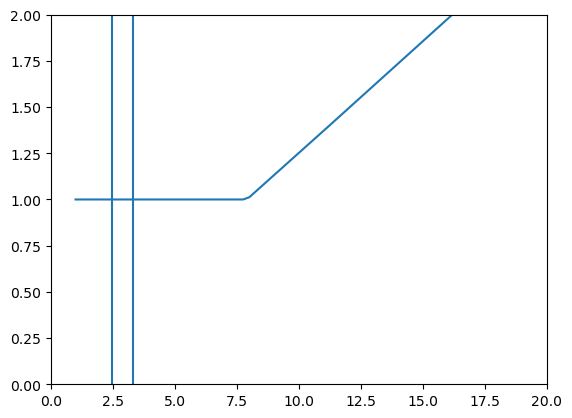

In [70]:
n_factor = fract[np.argmax(peak_sum_diffnorm)]
plt.plot(1/alpha_xtrs, fract)
plt.axvline(1/pk_val)
plt.axvline(1/alpha)
plt.xlim(0,20)
plt.ylim(0,2)
pk_val*n_factor, pk_val/n_factor

Text(0.5, 0, 'occupancy')

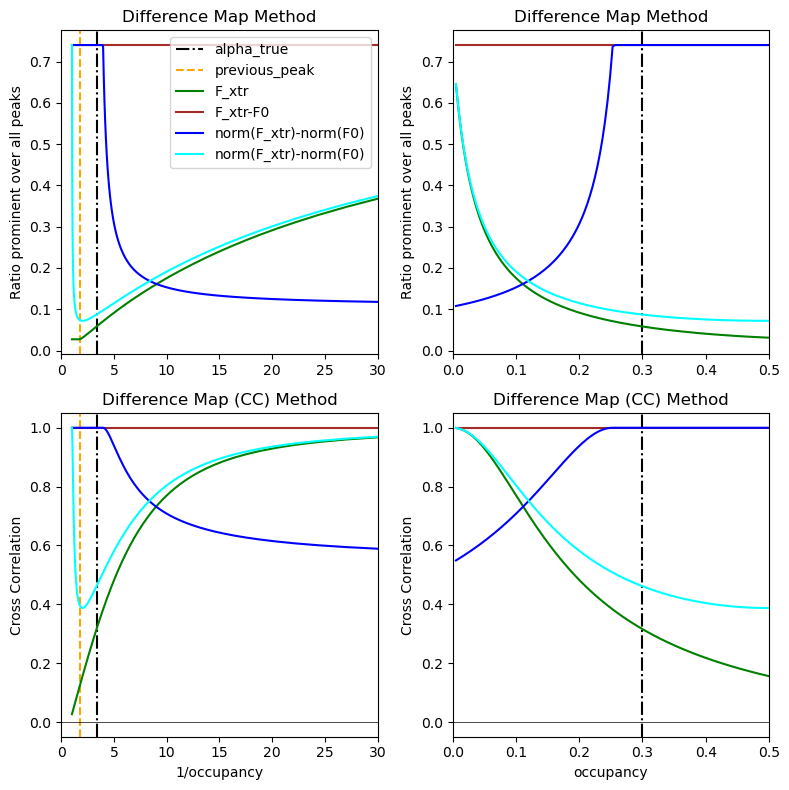

In [73]:
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    # ax.set_ylim(.73,0.75)
    
for ax in axs[:,0] :
    # ax.axvline(1/(alpha/2),c="k", linestyle="-", label="alpha_true/2")
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(1/pk_val,c="orange", linestyle="--", label="previous_peak")
    ax.set_xlim(0,30)
    
for ax in axs[:,1] :
    # ax.axvline(alpha/2,c="k", linestyle="-", label="alpha_true")
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(pk_val,c="orange", linestyle="--", )
    ax.set_xlim(0,0.5)
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
# ax.plot(1/alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
ax.plot(1/alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
# ax.plot(alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
ax.plot(alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(1/alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
ax.plot(1/alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
ax.plot(alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("occupancy")


Something reassuring about the normed difference is, that the lines of the cross correlation measure and absolute sums resemble each other - like in Elke's work. Also there is a single positive peak.

Yet, this peak is quite a bit off from what the true alpha is. The comparison is not very fair however as we saw above, the scaling shifts the relative strength of $F_0$ and $F_{xtr}$ significantly - and thus attempts to pick the one with the best "snr" or the highest Cross correlation to the difference state. 

What I struggle with is how to go back to the best $F_{xtr}$ after determining this best state. 

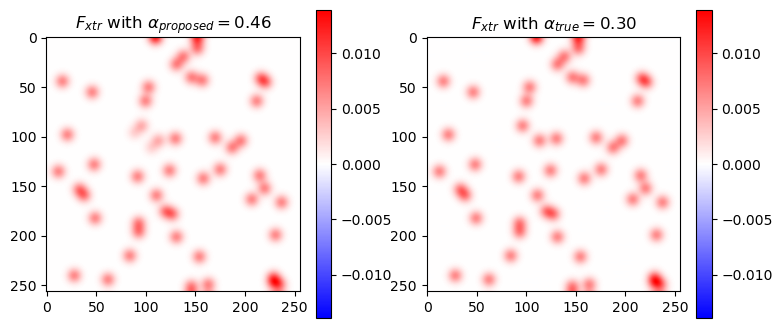

In [67]:
def compare_output(alpha_chosen, titles, noise_level=0):
    f_prop = make_f_xtr_phased(np.array(alpha_chosen), f_dark, (f_light-f_dark)/2, noise_level=noise_level)
    rho_proposed = np.fft.ifft2(f_prop).real
    fig, axs = plt.subplots(1,len(titles), figsize=(len(titles)*4+1,4))
    for ii, rho_prop in enumerate(rho_proposed):
        vmax = np.max(rho_prop)
        ax = axs[ii]
        im = ax.imshow(rho_prop, cmap="bwr", vmin=-vmax, vmax=vmax)
        ax.set_title(titles[ii])
        plt.colorbar(im)

# pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]
alpha_chosen = [pk_val, alpha]
titles = [r"$F_{xtr}$ with $\alpha_{proposed} = " + f"{pk_val:.2f}$", r"$F_{xtr}$ with $\alpha_{true} = "+ f"{alpha:.2f}$"]
compare_output(alpha_chosen, titles)

Text(0, 0.5, 'Full view')

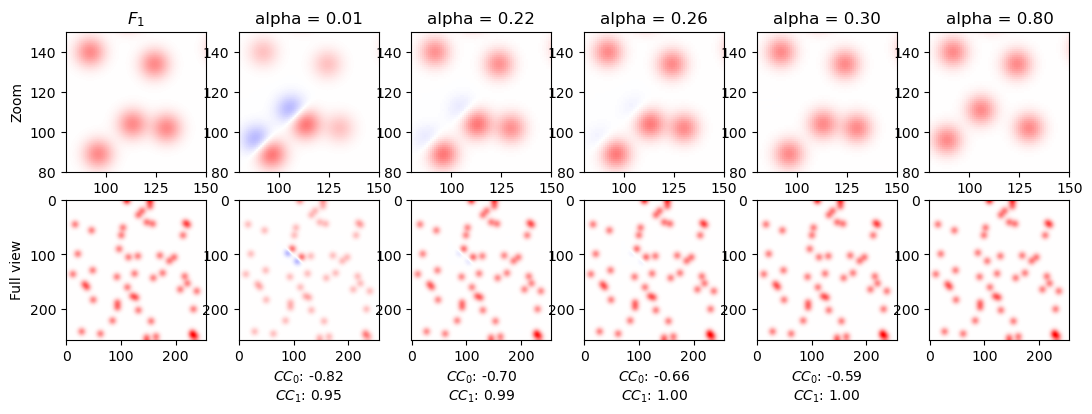

In [50]:
alpha_chosen = np.array([0.01, pk_val, alpha, 0.8])
alpha_chosen = np.array([0.01, 0.22, 0.26, alpha,  0.8])

# copy from make_f_xtr
delta_f = (np.abs(f_light) - np.abs(f_dark))
delta_f_with_phase = delta_f * np.exp(1j * np.angle(f_dark))


tit = [f"alpha = {aa:.2f}" for aa in alpha_chosen]
titles =  ["$F_1$", *tit, "$F_0$",]
lims = (80,150)
fig, axso = plt.subplots(2,6, figsize=(13,4))
rho_proposed_list = []
for axs in axso:
    ax= axs[0]
    ax.imshow(obj1/np.max(obj1), cmap="bwr", vmin=-1,vmax=1)
    for ii,ax in enumerate(axs[1:-1]):
        

        # math
        f_proposed = 2/alpha_chosen[ii]*(f_light-f_dark)+f_dark
        rho_proposed = np.fft.ifft2(f_proposed).real
        rho_proposed = (rho_proposed/np.max(rho_proposed) + obj0/np.max(obj0))/2
        rho_proposed_list.append(rho_proposed)
        # end math

        ax.imshow(rho_proposed, cmap="bwr", vmin=-1,vmax=1)
    ax= axs[-1]
    ax.imshow(obj0/np.max(obj0), cmap="bwr", vmin=-1,vmax=1)
for ii,ax in enumerate( axso[0]):
    ax.set_title(titles[ii])
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
for ii,ax in enumerate( axso[1,1:-1]):
    
    cc0 = pearsonr(rho_proposed_list[ii].flatten(), obj0.flatten())[0]
    cc1 = pearsonr(rho_proposed_list[ii].flatten(), obj1.flatten())[0]
    
    cc0 = pearsonr(rho_proposed_list[ii][mask_pks], obj0[mask_pks])[0]
    cc1 = pearsonr(rho_proposed_list[ii][mask_pks], obj1[mask_pks])[0]
    ax.set_xlabel(f"$CC_0$: {cc0:.2f}\n$CC_1$: {cc1:.2f}")

axso[0,0].set_ylabel("Zoom")
axso[1,0].set_ylabel("Full view")

I don't have a motivation for the image I am creating here, namely taking the average between the normalized versions of $F_{xtr}$ and $F_{0}$ and yet I do get more or less what they observed. But this does seem like a sound strategy to create the 'proper' extrapolated image via the Xtrapol8 method. 

The cross correlation seems to peak at that alpha - in the region of interest. The overall cross correlation is higher for $\alpha =0.3 = \alpha_{true}$. This makes sense as that image seems to have way less noise. 

No colorbar because everything is normed to 1.

# Diffmap fucking around

In [51]:
from occupancy import  x8_density_map_fdiff_factor, x8_density_map_f1
f_mix = np.fft.fft2(delta_obj)
true_phase = np.angle(f_mix)
rand_phase = np.random.uniform(size=true_phase.shape)*2*np.pi

alpha_xtrs = np.linspace(5e-3,1,150 )

f_xtrs = make_f_xtr_phased(alpha_xtrs, f_dark, f_light-f_dark, noise_level=0)
peak_sum, real_CC, peak_pos, peak_neg = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj, posneg=True)
# peak_sum_diffnorm, real_CC_diffnorm, fract = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj, inspect=True)
peak_sum_diffnorm, real_CC_diffnorm, peak_pos_diffnorm, peak_neg_diffnorm = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj, posneg=True)

peak_sum_difffact, real_CC_difffact = x8_density_map_fdiff_factor(f_xtrs/alpha_xtrs[:,None,None], mask_pks, obj0, delta_obj, 1)
peak_sum_diff_noisyf0, real_CC_diff_noisyf0 = x8_density_map_fdiff_noisyf0(f_xtrs, mask_pks, obj0, delta_obj)

#print(np.max(),axis=(1,2)))

pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]

(0.13316230741877194, 0.13060844554001605)

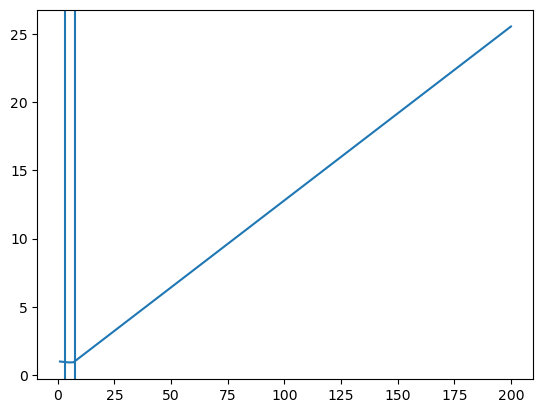

In [91]:
n_factor = fract[np.argmax(peak_sum_diffnorm)]
plt.plot(1/alpha_xtrs, fract)
plt.axvline(1/pk_val)
plt.axvline(1/alpha)
# plt.xlim(0,20)
# plt.ylim(0,2)
pk_val*n_factor, pk_val/n_factor

Text(0.5, 0, 'occupancy')

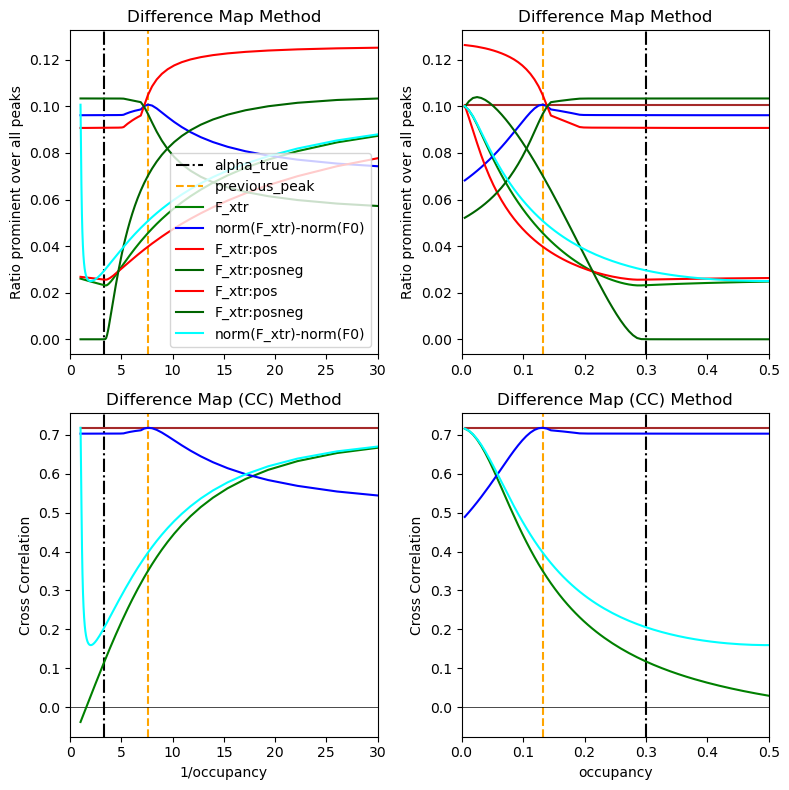

In [90]:
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[:,0] :
    # ax.axvline(1/(alpha/2),c="k", linestyle="-", label="alpha_true/2")
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(1/pk_val,c="orange", linestyle="--", label="previous_peak")
    ax.set_xlim(0,30)
    
for ax in axs[:,1] :
    # ax.axvline(alpha/2,c="k", linestyle="-", label="alpha_true")
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    ax.axvline(pk_val,c="orange", linestyle="--", )
    ax.set_xlim(0,0.5)
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.plot(1/alpha_xtrs,peak_pos, label=r"F_xtr:pos",color="red")
ax.plot(1/alpha_xtrs,peak_neg, label=r"F_xtr:posneg",color="darkgreen")
ax.plot(1/alpha_xtrs,peak_pos_diffnorm, label=r"F_xtr:pos",color="red")
ax.plot(1/alpha_xtrs,peak_neg_diffnorm, label=r"F_xtr:posneg",color="darkgreen")
# ax.plot(1/alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
ax.plot(1/alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.plot(alpha_xtrs,peak_pos, label=r"F_xtr:pos",color="red")
ax.plot(alpha_xtrs,peak_neg, label=r"F_xtr:posneg",color="darkgreen")
ax.plot(alpha_xtrs,peak_pos_diffnorm, label=r"F_xtr:pos",color="red")
ax.plot(alpha_xtrs,peak_neg_diffnorm, label=r"F_xtr:posneg",color="darkgreen")
# ax.plot(alpha_xtrs,peak_sum_diff_noisyf0, label=r"norm(F_xtr)-norm(F0)",color="r")
ax.plot(alpha_xtrs,peak_sum_difffact, label=r"norm(F_xtr)-norm(F0)",color="cyan")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(1/alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
ax.plot(1/alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
# ax.plot(alpha_xtrs,real_CC_diff_noisyf0, label=r"norm: F_xtr-F0",color="r")
ax.plot(alpha_xtrs,real_CC_difffact, label=r"norm: F_xtr-F0",color="cyan")
ax.set_xlabel("occupancy")


# Negative Sum Explosion (Marius Method)

In [75]:
alpha_invs = (np.arange(0,20,0.1)+1e-10)
alpha_xtrs = 1/alpha_invs
from occupancy import marius
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
f_xtrs = make_f_xtr_phased(alpha_xtrs, f_dark, f_light-f_dark, noise_level=0)
dens_xtrs, neg_sum = marius(f_xtrs)

In [76]:
noise_level

0

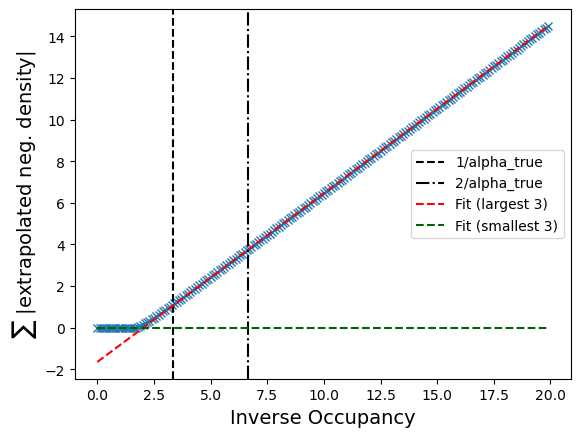

In [77]:
from scipy import stats
n_largest = 3
m1 = alpha_invs>alpha_invs[-n_largest]
m2 = alpha_invs<alpha_invs[n_largest]
res_1 = stats.linregress(alpha_invs[m1], -neg_sum[m1])
res_2 = stats.linregress(alpha_invs[m2], -neg_sum[m2])
# res_11 = stats.linregress(alpha_invs[m11], -neg_sum[m11])
# res_22 = stats.linregress(alpha_invs[m22], -neg_sum[m22])

alpha_line = np.linspace(np.min(alpha_invs), np.max(alpha_invs),5,)

plt.plot(alpha_invs,neg_sum*-1, "x" )
plt.axvline(1/alpha,c="k",linestyle="--", label="1/alpha_true")
plt.axvline(2/alpha,c="k",linestyle="-.", label="2/alpha_true")


plt.plot(alpha_line, res_1.intercept+res_1.slope*alpha_line,c="red",linestyle="--", label=f"Fit (largest {n_largest})")
plt.plot(alpha_line, res_2.intercept+res_2.slope*alpha_line, c="darkgreen",linestyle="--",label=f"Fit (smallest {n_largest})")
# plt.plot(alpha_line, res_11.intercept+res_11.slope*alpha_line,c="purple",linestyle="--", label="Fit (all larger )")
plt.legend()
# plt.plot(alpha_line, res_22.intercept+res_22.slope*alpha_line, c="purple",linestyle="--")
# plt.ylim(20,40)
fs = 14
plt.xlabel("Inverse Occupancy", fontsize = fs)
plt.ylabel(r"$\sum$ |extrapolated neg. density|", fontsize=fs)
plt.show()
# plt.title("'Marius Method'")
# plt.savefig("mariusmethod.png")

In [78]:
intersection = (res_2.intercept-res_1.intercept) / (res_1.slope-res_2.slope)
alpha_intersect = 2/intersection

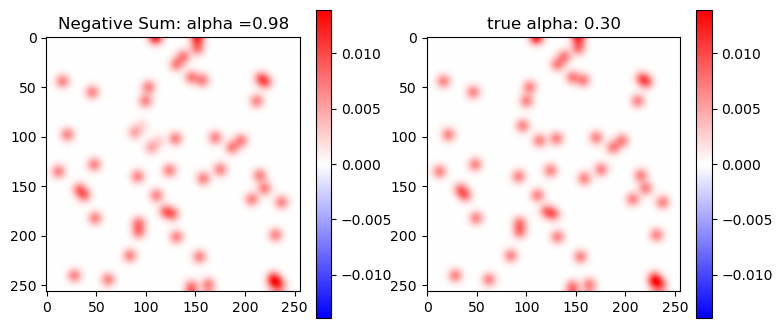

In [79]:

alpha_chosen = [alpha_intersect, alpha]
titles=[r'Negative Sum: alpha ='+ f'{alpha_intersect:.2f}', f'true alpha: {alpha:.2f}']
compare_output(alpha_chosen, titles)


In this version it seems slightly off, but my eye would be too.

# PanDDA Method

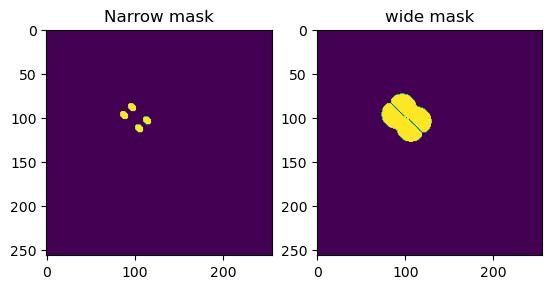

In [81]:
delta_obj = alpha*(obj1-obj0)
mask_pks_strict = np.abs(delta_obj)>0.001
mask_pks_lax = np.abs(delta_obj)>0.00001
fig, axs = plt.subplots(1,2)
ax = axs[0]
ax.set_title("Narrow mask")
ax.imshow(mask_pks_strict)
ax = axs[1]
ax.set_title("wide mask")
ax.imshow(mask_pks_lax)
# ax = axs[1]
# ax.imshow(mask_pks)


What I found was that the PanDDA method is very dependent on what exactly is flagged as the region of interest. So for the narrow selection, we find a broad peak the center of which is close to the true solution. The wider area attempt is quite a bit off however.

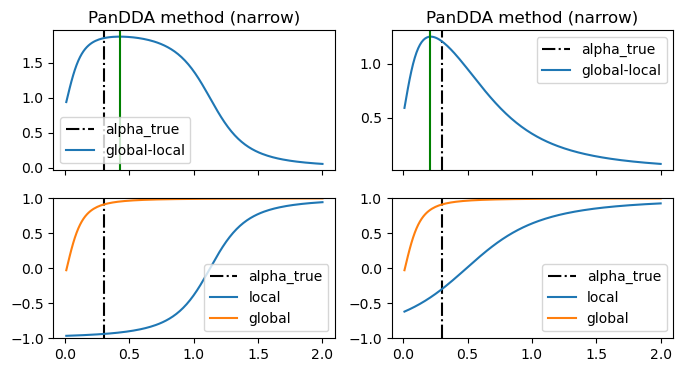

In [83]:
alpha_xtrs = np.linspace(1e-2,2,150 )
f_xtrs = make_f_xtr_phased(alpha_xtrs, f_dark, f_light-f_dark, noise_level=0)
mean_local_strict, mean_global_strict = pandda(f_dark, f_xtrs, mask_pks_strict)
mean_local_lax, mean_global_lax = pandda(f_dark, f_xtrs, mask_pks_lax)

mean_local, mean_global =  mean_local_strict, mean_global_strict
# mean_local, mean_global =  mean_local_lax, mean_global_lax
ml = [mean_local_strict, mean_local_lax]
mg = [mean_global_strict, mean_global_lax]
titles = ["narrow mask", "wide mask"]

fig, axso = plt.subplots(2,2, figsize =(8,4), sharex=True)
for axs, mean_local, mean_global, title in zip(axso.T, ml, mg, titles):

# fig, axs = plt.subplots(3, )
    ax = axs[0]
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
    pk_val_narrow = alpha_xtrs[np.argmax(mean_global-mean_local)]
    ax.axvline(pk_val_narrow, color="green")
    md = mean_global-mean_local
    # print(md[md>=1.8])
    # ax.set_ylim(1., 1.9)
    ax.legend()
    ax.set_title("PanDDA method (narrow)")
    ax = axs[1]
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.plot(alpha_xtrs,mean_local, label="local") 
    ax.plot(alpha_xtrs, mean_global,label="global")
    ax.set_ylim(-1,1)
    ax.legend()
    # ax = axs[2]
    # ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    # ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local")
    # ax.set_xlim(0,1)
    # ax.legend()


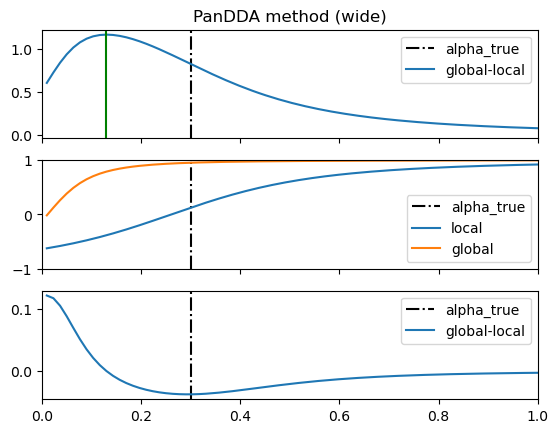

In [20]:
alpha_xtrs = np.linspace(1e-2,2,150 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
mean_local, mean_global = pandda(f_dark, f_xtrs, mask_pks_lax)
fig, axs = plt.subplots(3, sharex=True)
ax = axs[0]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
pk_val_wide = alpha_xtrs[np.argmax(mean_global-mean_local)]
ax.axvline(pk_val_wide, color="green")
ax.legend()
ax.set_title("PanDDA method (wide)")
ax = axs[1]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,mean_local, label="local") 
ax.plot(alpha_xtrs, mean_global,label="global")
ax.set_ylim(-1,1)
ax.legend()
ax = axs[2]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local") 
ax.set_xlim(0,1)
ax.legend()



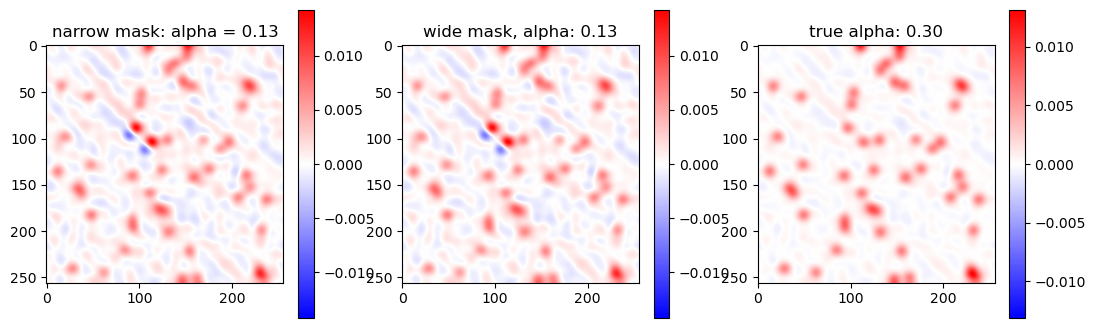

In [21]:
alpha_chosen = [pk_val_narrow, pk_val_wide, alpha]
titles=[f'narrow mask: alpha = {pk_val_narrow:.2f}', f'wide mask, alpha: {pk_val_wide:.2f}', f'true alpha: {alpha:.2f}']
compare_output(alpha_chosen, titles)


This method, too, finds a result that to my untrained eyes looks very similar to the good result - if one describes the region of interest well.

For real experimental data, this task seems to be rather tough.

# Still here
I am not sure what to do with this. I will probably delete it in a coming push

In [22]:
alpha_xtrs = np.linspace(0,1,340)+1e-10
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=2, noise_level = noise_level)
corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))

Text(0, 0.5, 'Gradient of CC')

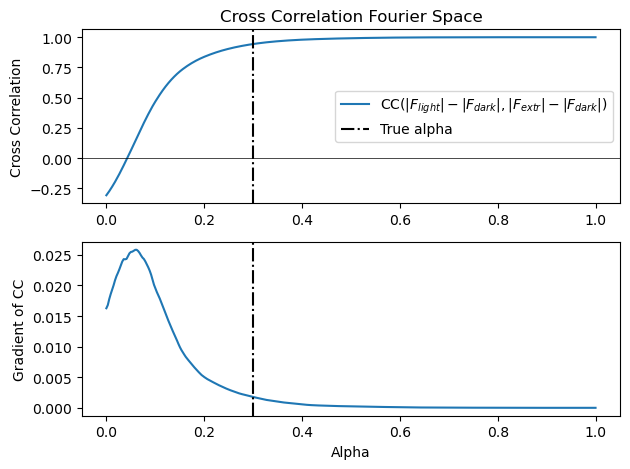

In [23]:
fig, axs = plt.subplots(2, tight_layout=True)
ax = axs[0]
ax.plot(alpha_xtrs,corr_x8, label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axvline(alpha,c="k", linestyle="-.", label="True alpha")
ax.axhline(0,c="k", linewidth=.5, )
ax.legend()
ax.set_ylabel("Cross Correlation")
ax.set_title("Cross Correlation Fourier Space")
ax = axs[1]

ax.plot(alpha_xtrs,np.gradient(corr_x8), label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axvline(alpha,c="k", linestyle="-.", label="True alpha")
# ax.axvline(alpha/2,c="k", linestyle="-.", label="True alpha/2")
# ax.legend()
ax.set_xlabel("Alpha")
ax.set_ylabel("Gradient of CC")

In [24]:
pearsonr(obj1.flatten(),obj0.flatten())
pearsonr(obj1[~mask_pks].flatten(),obj0[~mask_pks].flatten())

PearsonRResult(statistic=0.9980947354856378, pvalue=0.0)


# Disregard 
The following cell contains my previous version.

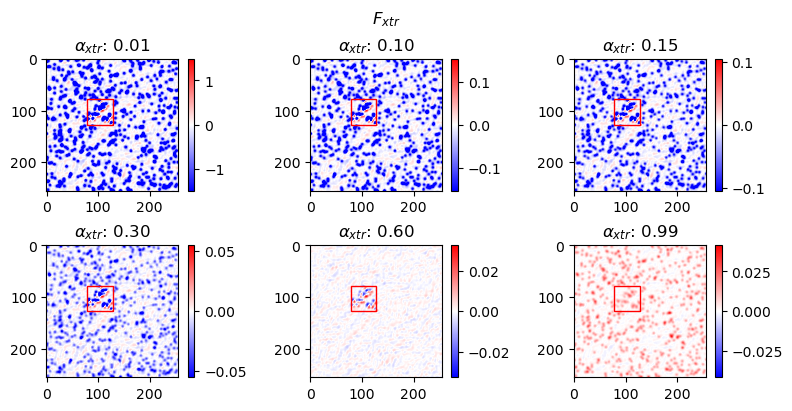

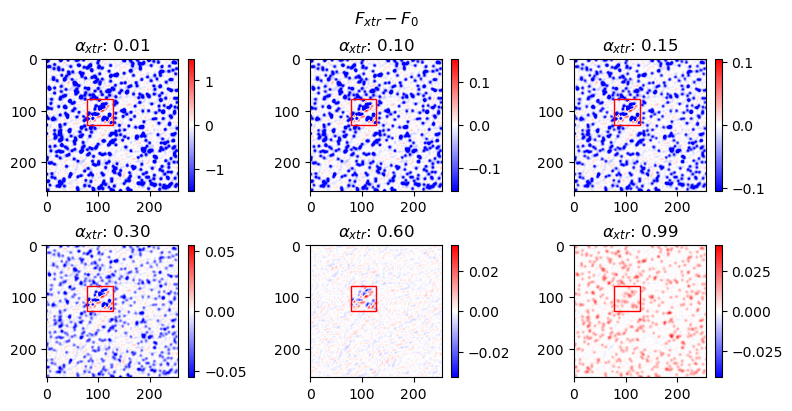

cc_mix=-0.17872011826817266	cc_2alph_comb=0.0838466351448773 cc_2alph_0=0.9637286290401879
596.0000000000001 [257.99060432]
[2.31016165]



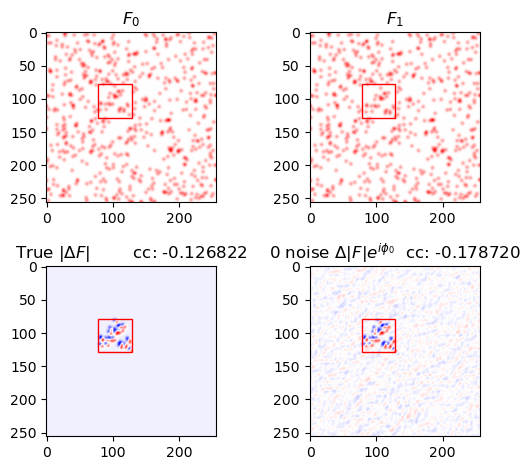

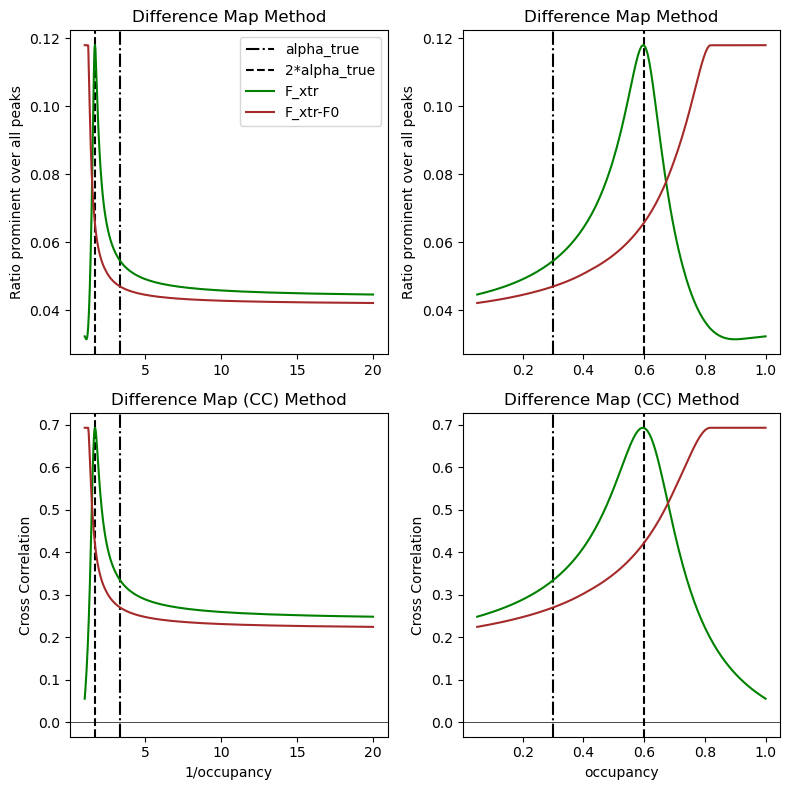

In [25]:
from occupancy import x8_density_map_f1,x8_density_map_fdiff

def self_contained():
    img_mid = 128
    boxleng = -50
    
    obj1, obj0 =  make_objs(blur_by=2) # previous image 
    delta_obj = obj1-obj0
    mask_pks = np.abs(delta_obj)>0.01
    
    delta_obj = alpha*obj1-alpha*obj0
    alpha_xtrs = np.linspace(5e-2,1,150 )
    f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=True)

    
    alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .99])
    # alpha_xtrs = alpha_xtrs_vis
    f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = 0)
    dens_xtrs_vis, _ = marius(f_xtrs_vis)
    # dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
    fig1, axs1 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    fig2, axs2 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    steps = 1
    for ax1,ax2, alpha_xtr, arr in zip(axs1.flat,axs2.flat, alpha_xtrs_vis,dens_xtrs_vis):
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        raw = [r"$\alpha_{xtr}$",
               r"$\alpha_t$"]
        tit = f"{raw[0]}: {alpha_xtr:.2f}"
        ax1.set_title(tit)
        ax2.set_title(tit)
        vmax = np.max(arr)
        im = ax1.imshow(arr, cmap="bwr",vmin=-vmax, vmax=vmax)
        plt.colorbar(im)
        prefactor =596 
        diff = (arr-obj0/prefactor)
        vmax = np.max(diff)
        im = ax2.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
        plt.colorbar(im)

    fig1.suptitle("$F_{xtr}$")
    fig2.suptitle("$F_{xtr} - F_0$")

    plt.show()    
    fig, axsi = plt.subplots(2,2, tight_layout=True)
    axs = axsi.flat

    obj_diff = obj1-obj0
    f_diff = np.fft.fftn(obj_diff)
    obj_diff_conj = np.fft.ifftn(np.conj(f_diff)* np.exp(2j*np.angle(f_dark))).real
    obj_diff_comb = (obj_diff + obj_diff_conj)/2


    for ax in axs:
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax = axs[0]
    ax.set_title(r"$F_0$")
    ax.imshow(obj0, cmap= "bwr", vmin=-np.max(obj0))
    ax = axs[1]
    ax.set_title(r"$F_1$")
    ax.imshow(obj1, cmap= "bwr", vmin =-np.max(obj1))

    ax = axs[2]
    cc_true = pearsonr(obj0.flatten(), obj_diff.flatten())[0]
                       
    ax.set_title(r"True $|\Delta F|$"+f"\t cc: {cc_true:2f}")
    ax.imshow(obj_diff, cmap = "bwr", )

    ax = axs[3]
    cc_mix = pearsonr(obj0.flatten(), obj_diff_comb.flatten())[0]
    cc_2alph_comb = pearsonr(dens_xtrs_vis[5].flatten(), obj_diff_comb.flatten())[0]
    # cc_comb_0 = pearsonr(obj0.flatten(), obj_diff_comb.flatten())[0]
    cc_2alph_0 = pearsonr(obj0.flatten(), dens_xtrs_vis[5].flatten())[0]
    print(f"{cc_mix=}\t{cc_2alph_comb=}{ cc_2alph_0=}")
    ax.set_title(r"0 noise $\Delta |F|e^{i\phi_0}$"+f"\t cc: {cc_mix:2f}")
    ax.imshow(obj_diff_comb, cmap = "bwr",)
    print( np.sum(obj0.flatten()), np.sum(np.abs(dens_xtrs_vis[5])).flatten())
    print( np.sum(obj0.flatten())/ np.sum(np.abs(dens_xtrs_vis[5])).flatten())
    print()
    
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
    peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
    peak_sum4, real_CC4 = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj)
    
    
    fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
    for ax in axs[0] :
        ax.set_ylabel("Ratio prominent over all peaks")
        ax.set_title("Difference Map Method")

    for ax in axs[:,0] :
        ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
        ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")

    for ax in axs[:,1] :
        ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
        ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")

    for ax in axs[1] :
        ax.axhline(0,c="k", linewidth=.5, )
        ax.set_ylabel("Cross Correlation")
        ax.set_xlabel("Alphas")
        ax.set_title("Difference Map (CC) Method")

    ax = axs[0,0]
    ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
    ax.plot(1/alpha_xtrs,peak_sum4, label=r"F_xtr-F0",color="brown")
    ax.legend()

    ax = axs[0,1]
    ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
    ax.plot(alpha_xtrs,peak_sum4, label=r"$\phi_{0}$",color="brown")

    ax = axs[1,0]
    ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
    ax.plot(1/alpha_xtrs,real_CC4, label=r"$\phi_{0}$",color="brown")
    ax.set_xlabel("1/occupancy")

    ax = axs[1,1]
    ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
    ax.plot(alpha_xtrs,real_CC4, label=r"F_xtr-F0",color="brown")
    ax.set_xlabel("occupancy")
self_contained()

This section here helped me to understand what was going on, made me realize the smoothing aspect and for now i wanted to keep it here. 

